In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/repo_tesis/entorno_tesis_Molina"
!source bin/activate

Mounted at /content/drive
/content/drive/My Drive/repo_tesis/entorno_tesis_Molina


Importo las librerías

In [2]:
!pip install lmoments3

import numpy as np
import pickle
from joblib import dump
import pandas as pd
import sys
import matplotlib.pyplot as plt

sys.path.append("/content/drive/My Drive/repo_tesis/lib")
import functions as f

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.6 MB/s eta 0:00:00


Levanto los datos

In [3]:
%cd "/content/drive/My Drive/repo_tesis/data"
# Load data
file = open('MyoArmband_data_exp1_cor.pickle', 'rb')
MyoArm_data = pickle.load(file)
file.close()

/content/drive/My Drive/repo_tesis/data


Defino los parámetros que voy a usar

In [4]:
fs = MyoArm_data['S1']['info']['fs'] # Frecuency in Hz
nOfSubjects = 10 # N° of Subjects [1,...,10]- cantidad de sujetos con lo que voy a trabajar
nChannels = 16 # N° of Channels- numero de canales con los que quiero trabajar- el maximo es MyoArm_data['S1']['emg'].shape[1]+1
w_ms = 200 # Window length in ms. Largo de la ventana sobre la que calculo las features
s_ms = 50 # Window increment in ms. Incremento de ventana sobre la que calculo las features, o separación entre cada ventana consecutiva
W_s = int(fs*w_ms/1000) # Window length in samples
I_s = int(fs*s_ms/1000) # Window increment in samples

Extraigo los datos

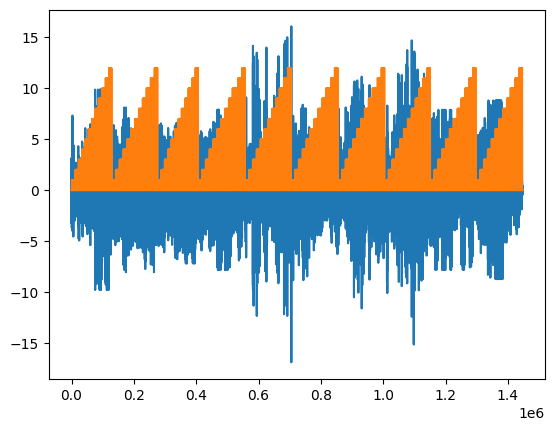

In [5]:
data_list = []  # en cada elemento de la lista guardo los datos de un sujeto, luego los concateno
label_list = [] # lo mismo que para la anterior
suject_list = []   # aqui se indica a que sujeto pertenece la senal a lo largo del tiempo

for i in range(1, nOfSubjects+1):
    data_list.append(MyoArm_data['S'+str(i)]['emg'])
    label_list.append(MyoArm_data['S'+str(i)]['label'])
    suject_list.append(MyoArm_data['S'+str(i)]['label']*0 + i)

# Ahora tengo que concatenar los elementos de la lista
data = []
label = []
suject = []
for i in range(len(data_list)):
    data.extend(data_list[i])
    label.extend(label_list[i])
    suject.extend(suject_list[i])

data = np.array(data)
label = np.array(label)
suject = np.array(suject)

# Visualizacion de la senal 1 de todos los sujetos
plt.figure()
plt.plot(data[:, 0])
plt.plot(label)
plt.show()

# Quiero identificar cada ventana de gesto con un numero
indices_ventanas = np.where(np.diff(label)!=0)[0]
id_ventanas_gestos = np.zeros(int(len(indices_ventanas)/2))
# Me voy a quedar solo con los elementos pares que son los que marcan el inicio de una ventana
# de esta forma la posicion en el vector los va a identificar, y el valor en la celda me permite ubicarlo, ya que es su principio
for i in range(int(len(indices_ventanas)/2)):
    id_ventanas_gestos[i] = indices_ventanas[2*i]


Ahora que tengo todos los datos juntos podria calcular las features.
Sin embargo no voy a calcular features en todas las ventanas posibles, me voy a quedar solo con las que se solapen determinado porcentaje con un lugar en el que label no sea 0, es decir que haya gesto. También voy a desechar las ventanas que abarquen dos gestos distintos.


In [6]:
ventanas_admitidas = []     # en cada elemento guardo los indices de las ventanas permitidas

# Esta es la cantidad de ventanas que supuestamente tengo que probar. Esto lo saque del codigo de renato
l = int((len(data)-W_s+I_s)/I_s) # N° of windows in the register

# Parametros:
costo_gesto0 = 12    # Costo expresado en ventanas admitidas con solapamiento, para ingresar una ventana de reposo
fraccion_solapamiento_ventana = 0.5
condicion_solapamiento = fraccion_solapamiento_ventana*W_s  # cantidad de muestras minima de solapamiento para admitir la ventana

barrita_costo_gesto0 = 0    # Se le suma uno cuando agrego una ventana admitida con solapamiento, y se le resta el valor de cupo luego de agregar una de reposo
delay_muestras_reposo = I_s

for i in range(l):   # 10009, 10010
    # me voy a crear una ventana auxiliar para compararla con las etiquetas y ver si hay superposicion
    vent_aux = np.zeros(len(label))
    vent_aux[i*I_s: i*I_s+W_s] = 1

    comp = vent_aux*label   # comparo la ventana con el vector label
    if np.max(comp) != 0:   # si el maximo es 0 es porque no se superponen
        comp = comp/np.max(comp)    # para que la suma de la cantidad de muestras que se superponen
        muestras_super = np.sum(comp)
    else:
        if barrita_costo_gesto0 >= costo_gesto0:
            ventanas_admitidas.append([i*I_s+delay_muestras_reposo, i*I_s+W_s+delay_muestras_reposo, -1, 0, -1])    # TODO no me interesa identificar ni entre que repeticiones está, ni el sujeto, no?
            barrita_costo_gesto0 += -costo_gesto0
    if (np.max(comp) != 0) and (muestras_super >= condicion_solapamiento):
        indices_no_cero = np.where(np.diff(comp) != 0)  # esto es para chequear que la ventana no abarque dos ventanas de gestos distintas
        if len(indices_no_cero[0]) < 3:
            # Para identificar la ventana de gesto voy a buscar el comienzo de ventana mas cercano menor al primer elemento de comp distinto de 0
            ind_comp_no_cero = np.where(comp != 0)[0]
            id_ventana = np.argmin(np.abs(ind_comp_no_cero[0] - id_ventanas_gestos))
            if id_ventanas_gestos[id_ventana] > ind_comp_no_cero[0]:    # el comienzo tiene que ser menor a la parte en la que coindicen, porque una ventana no puede abarcar dos ventanas de gestos distintas
                id_ventana += -1    # esto es dificil que pase pero estaria bueno chequear que funcione

            # Para averiguar el gesto y sujeto evaluamos label y suject en alguna muestra donde comp no sea cero
            label_act = label[ind_comp_no_cero[0]]
            suject_act = suject[ind_comp_no_cero[0]]

            # Principio, fin de ventana, identificador, gesto de la ventana, sujeto
            ventanas_admitidas.append([i*I_s, i*I_s+W_s, id_ventana, label_act, suject_act])
            barrita_costo_gesto0 += 1
for i in range(len(ventanas_admitidas)):
  if ventanas_admitidas[i][4] == -1:
    ventanas_admitidas[i][4] = ventanas_admitidas[i-1][4]

ventanas_admitidas = np.array(ventanas_admitidas)
ind_reposo = np.where(ventanas_admitidas[:, 2]==-1)[0]  # me fijo los indices que son reposo
ind_ventanas_reposo = np.where(np.diff(ind_reposo)!=1)[0]   # calculos los bordes de cada "repeticion de reposo"

# Insertar el valor al principio del array
ind_ventanas_reposo = np.insert(ind_ventanas_reposo, 0, 0)

# Me fijo la cantidad de repeticiones, para empezar a numerar a las repeticiones de reposo desde ahi
max_repeticiones = np.max(ventanas_admitidas[:, 2])

for i in range(len(ind_ventanas_reposo)):
    if i==0:
        ini = ind_reposo[ind_ventanas_reposo[i]]
        fin = ind_reposo[ind_ventanas_reposo[i+1]]+1
    elif i==len(ind_ventanas_reposo)-1:
        ini = ind_reposo[ind_ventanas_reposo[i]+1]
        fin = ind_reposo[-1]+1
    else:
        ini = ind_reposo[ind_ventanas_reposo[i]+1]
        fin = ind_reposo[ind_ventanas_reposo[i+1]]+1
    ventanas_admitidas[ini:fin, 2] = max_repeticiones + i + 1



Cálculo de features

In [7]:
l = len(ventanas_admitidas)

zcThreshold = 0.05
sscThreshold = 0.05
rms = np.zeros(l)
zc = np.zeros(l)
ssc = np.zeros(l)
wl = np.zeros(l)
mav = np.zeros(l)
ls = np.zeros(l)
mfl = np.zeros(l)
msr = np.zeros(l)
wamp = np.zeros(l)
iav = np.zeros(l)
dasdv = np.zeros(l)
_var = np.zeros(l)
DWT1 = np.zeros(l)
DWT2 = np.zeros(l)
DWT3 = np.zeros(l)

FEATURES = pd.DataFrame()
for j in range(nChannels):
    for i in range(l):
        wl[i] = f.wl(data[:,j][ventanas_admitidas[i][0]:ventanas_admitidas[i][1]])
        zc[i] = f.zc(data[:,j][ventanas_admitidas[i][0]:ventanas_admitidas[i][1]], zcThreshold)
        ssc[i] = f.ssc(data[:,j][ventanas_admitidas[i][0]:ventanas_admitidas[i][1]], sscThreshold)
        rms[i] = f.rms(data[:,j][ventanas_admitidas[i][0]:ventanas_admitidas[i][1]])
        mav[i] = f.mav(data[:,j][ventanas_admitidas[i][0]:ventanas_admitidas[i][1]])
        ls[i] = f.ls(data[:,j][ventanas_admitidas[i][0]:ventanas_admitidas[i][1]])
        mfl[i] = f.mfl(data[:,j][ventanas_admitidas[i][0]:ventanas_admitidas[i][1]])
        msr[i] = f.msr(data[:,j][ventanas_admitidas[i][0]:ventanas_admitidas[i][1]])
        wamp[i] = f.wamp(data[:,j][ventanas_admitidas[i][0]:ventanas_admitidas[i][1]])
        iav[i] = f.iav(data[:,j][ventanas_admitidas[i][0]:ventanas_admitidas[i][1]])
        dasdv[i] = f.dasdv(data[:,j][ventanas_admitidas[i][0]:ventanas_admitidas[i][1]])
        _var[i] = f._var(data[:,j][ventanas_admitidas[i][0]:ventanas_admitidas[i][1]])
        DWT1[i],DWT2[i],DWT3[i] = f.DWT(data[:,j][ventanas_admitidas[i][0]:ventanas_admitidas[i][1]])
    FEATURES["wl_c"+str(j+1)] = wl/max(abs(wl))
    FEATURES["zc_c"+str(j+1)] = zc/max(abs(zc))
    FEATURES["ssc_c"+str(j+1)] = ssc/max(abs(ssc))
    FEATURES["rms_c"+str(j+1)] = rms/max(abs(rms))
    FEATURES["mav_c"+str(j+1)] = mav/max(abs(mav))
    FEATURES["ls_c"+str(j+1)] = ls/max(abs(ls))
    FEATURES["mfl_c"+str(j+1)] = mfl/max(abs(mfl))
    FEATURES["msr_c"+str(j+1)] = msr/max(abs(msr))
    FEATURES["wamp_c"+str(j+1)] = wamp/max(abs(min(wamp)), max(wamp))
    FEATURES["iav_c"+str(j+1)] = iav/max(abs(iav))
    FEATURES["dasdv_c"+str(j+1)] = dasdv/max(abs(dasdv))
    FEATURES["var_c"+str(j+1)] = _var/max(abs(_var))
    FEATURES["DWT1_c"+str(j+1)] = DWT1/max(abs(DWT1))
    FEATURES["DWT2_c"+str(j+1)] = DWT2/max(abs(DWT2))
    FEATURES["DWT3_c"+str(j+1)] = DWT3/max(abs(DWT3))

/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients will experience boundary effects.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pywt/_multilevel.py:43: UserWarning: Level value of 2 is too high: all coefficients w

Guardado de las features y los labels calculados

In [8]:
ventanas_admitidas = np.array(ventanas_admitidas)
# Data exportation
labels = {'id_ventana':ventanas_admitidas[:, 2], 'id_gesto':ventanas_admitidas[:, 3], 'subjet': ventanas_admitidas[:, 4]}
labels = pd.DataFrame(labels)
dump(FEATURES, "../data/FEATURES_W200_I50.joblib")
dump(labels, "../data/label_W200_I50.joblib")

['../data/label_W200_I50.joblib']